# 自动化新素材评分 - 事后模型
* 目的：自动化新素材的评分流程；
* 思路：考虑计划指定的 策略+定向 的影响，选择相关素材下的计划上线情况对素材进行打分；

In [90]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
from impala.dbapi import connect
from impala.util import as_pandas
import json
import pymysql
import datetime
from tqdm.auto import tqdm
tqdm.pandas(desc="Processing!")

from script.weight import weights_calcul, weights_assign  # 线性最小二乘的权值编、解码脚本

## 数据模式一：素材评分历史
* select * from dws.dws_image_score_d
* 1条评分记录对应1个素材，1个素材对应1款游戏下的多个包体(game_id)，1个素材评分是1款游戏下该素材投放的所有计划情况；

In [91]:
df_score = pd.read_csv('/home/data/ch_data/dws_image_score_d.csv', encoding='GB2312')

* 删除hr字段

In [92]:
df_score = df_score.drop(['hr'],axis=1)

* 过滤：label_id无效标签

In [93]:
df_score = df_score[df_score['label_ids'].notnull() & (df_score['label_ids'] != '-1') & (df_score['label_ids'] != '\"-1')]

In [94]:
df_score['label_ids'] = df_score['label_ids'].str.replace('-1;', '')
df_score['label_ids'] = df_score['label_ids'].str.replace('-1,', '')
df_score['label_ids'] = df_score['label_ids'].str.replace('\"', '') 
df_score['label_ids'] = df_score['label_ids'].str.replace(';', ',')

In [95]:
# df_score = df_score[df_score['media_id'] == 10]

* 过滤：重复行

In [96]:
df_score = df_score[['image_id', 'image_name', 'label_ids', 'model_run_datetime', 'image_launch_time', 'dt', 'score']]
df_score.drop_duplicates(inplace=True)  # 注意keep=first

In [97]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70846 entries, 4346 to 190957
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   image_id            70846 non-null  int64 
 1   image_name          70846 non-null  object
 2   label_ids           70846 non-null  object
 3   model_run_datetime  70846 non-null  object
 4   image_launch_time   70846 non-null  object
 5   dt                  70846 non-null  object
 6   score               70846 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 4.3+ MB


In [98]:
df_score.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,dt,score
4346,23237,SSR1399-横版（混剪）,19,2020-12-18,2020-07-11,2020-12-18,478
4347,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,2020-12-18,571
4348,23509,SSR1414-竖版（3D混剪）,20,2020-12-18,2020-07-16,2020-12-18,500
4349,23552,SSR1419-横版（3D混剪）,20,2020-12-18,2020-07-14,2020-12-18,511
4350,23846,SSR1484-横版（3D混剪）,20,2020-12-18,2020-07-27,2020-12-18,540


## 数据模式二：计划信息+素材信息
* 1条评分记录对应1个素材，1个素材对应1款游戏下的多个包体(game_id)，1个素材评分是1款游戏下该素材投放的所有计划情况；

* 采集：计划信息

In [99]:
def get_game_id():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT dev_game_id AS game_id FROM db_data.t_game_config WHERE game_id = 1056 AND dev_game_id IS NOT NULL 
    '''
    cur.execute(sql)
    result_df = cur.fetchall()
    cur.close()
    conn.close()
    return result_df

* 采集：素材信息

In [100]:
image_info = pd.read_csv('/home/data/ch_data/image_info.csv')

In [101]:
def get_image_info():
    conn = pymysql.connect(host='192.168.0.79', port=3306, user='readonly',
                           passwd='Kc&r+z1ql9x8za4kzfk761weq8ozGv3ZpI;RMe,#+s%c>t')
    cur = conn.cursor(cursor=pymysql.cursors.DictCursor)
    sql = '''
        SELECT
            b.image_id,
            b.label_ids,
            b.game_ids,
            b.create_time
        FROM
            db_data_ptom.ptom_image_info b
        WHERE
            b.create_time >= '2019-01-01' 
    '''
    cur.execute(sql)
    result_df = pd.read_sql(sql, conn)
    cur.close()
    conn.close()
    return result_df

In [102]:
image_info_new = get_image_info()

* 合并

In [103]:
# 素材
image_info = image_info.append(image_info_new)
image_info.dropna(subset=['image_id'], inplace=True)
image_info['image_id'] = image_info['image_id'].astype(int)

In [104]:
# col = ['game_id', 'image_id', 'label_ids', 'create_time', 'smart_bid_type', 'hide_if_exists', 'budget', 'delivery_range', 'adjust_cpa', 'inventory_type', 'hide_if_converted', 'flow_control_mode', 'cpa_bid', 'auto_extend_enabled', 'gender', 'city', 'platform', 'launch_price', 'retargeting_tags_exclude', 'interest_categories', 'ac', 'android_osv', 'location_type', 'retargeting_tags_include', 'retargeting_type', 'ios_osv', 'interest_action_mode', 'age', 'action_categories', 'action_days', 'action_scene', 'deep_bid_type']
col = ['image_id', 'game_ids', 'label_ids','create_time']  # 'create_time'
df_create = image_info[col]

* 特殊字段

In [105]:
df_create = df_create.mask(df_create.applymap(str).eq('[]'))  # 空list替换为NaN

In [106]:
df_create = df_create.mask(df_create.applymap(str).eq('NONE'))  # NONE替换为NaN

* 过滤

In [107]:
from matplotlib import pyplot as plt

In [108]:
df_create = df_create[df_create['label_ids'].notnull()]  # 删除'label_ids'字段的NaN行

df_create = df_create[df_create['label_ids'].notnull() & (df_create['label_ids'] != '-1') & (df_create['label_ids'] != '\"-1')]
df_create['label_ids'] = df_create['label_ids'].str.replace('-1;', '')
df_create['label_ids'] = df_create['label_ids'].str.replace('-1,', '')
df_create['label_ids'] = df_create['label_ids'].str.replace('\"', '') 
df_create['label_ids'] = df_create['label_ids'].str.replace(';', ',')

In [109]:
df_create = df_create[df_create['game_ids'].notnull()]

df_create = df_create[df_create['game_ids'].notnull() & (df_create['game_ids'] != '-1') & (df_create['game_ids'] != '\"-1')]
df_create['game_ids'] = df_create['game_ids'].str.replace('-1;', '')
df_create['game_ids'] = df_create['game_ids'].str.replace('-1,', '')
df_create['game_ids'] = df_create['game_ids'].str.replace('\"', '') 
df_create['game_ids'] = df_create['game_ids'].str.replace(';', ',')

In [110]:
df_create['image_id'] = df_create['image_id'].astype(int)

In [111]:
df_create.drop_duplicates(inplace=True)

In [112]:
df_create.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9519 entries, 6597 to 23049
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   image_id     9519 non-null   int64         
 1   game_ids     9519 non-null   object        
 2   label_ids    9519 non-null   object        
 3   create_time  9519 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 371.8+ KB


In [113]:
df_create.head()

,image_id,game_ids,label_ids,create_time
6597,17144,"1001246,1001220,1001195,1001174,1001165,100116...",80,2019-09-10 10:42:38
9074,19636,"1001079,1001049,1000993,1000960,1000954,100094...",19,2020-01-10 14:21:51
9938,20518,"1000840,1000862,1000869,1000935,1000947,100095...",20,2020-03-11 17:54:45
10079,20659,"1001050,1001040,1001003,1000995,1000981,100072...",12,2020-03-16 22:55:00
10120,20700,"1001079,1001049,1000993,1000992,1000960,100095...",20,2020-03-19 20:00:35


## 拼接
* 从素材评分历史出发，每条素材评分的素材ID，关联计划+素材信息的所有game_ids，作为包体集合；

In [115]:
# df_score[df_score['image_id']==19636]  # 5个评分记录

In [116]:
# df_create[df_create['image_id']==19636]  # 7条计划记录

* 拼接素材与包体情况

In [117]:
# def merge_my(x, df):
#     """ 包体采集："""
#      # 对于匹配不到素材id的score记录，其'game_id'为''值
#     return ','.join(df[df['image_id']==x['image_id']]['game_id'].value_counts().index.astype(str).tolist())

# game_id_series = df_score.progress_apply(lambda x : merge_my(x, df_create), axis=1)

## 特征量化
* 1）label_ids;
* 2）game_ids;
* 3）~~image_name~~：横板、竖版、是否3D等特征;
* 4）~~image_launch_time~~：是否节假日、是否周末等特征;

* score分布情况

/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score', ylabel='Density'>

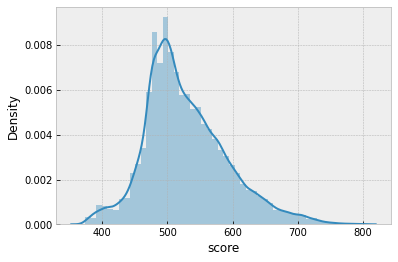

In [38]:
import seaborn as sns
sns.distplot(df['score'])

### label_ids字段处理
* 统计项：单因素加权量化 - 最小二乘

In [39]:
label_ids_mapping = weights_calcul(df, 'label_ids')  # 编码

In [40]:
df = weights_assign(df, label_ids_mapping, 'label_ids')  # 解码

100%|██████████| 51207/51207 [00:56<00:00, 906.24it/s]


In [41]:
df['label_ids'] = df['label_ids'].astype(float)

In [42]:
df.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,game_ids,score
0,23237,SSR1399-横版（混剪）,511.852283,2020-12-18,2020-07-11,"1000840,1000993,1001258,1001155,1001049",478
1,23509,SSR1414-竖版（3D混剪）,530.618506,2020-12-18,2020-07-16,"1001379,1001400,1000993,1000840,1001049,100125...",571
2,23509,SSR1414-竖版（3D混剪）,530.618506,2020-12-18,2020-07-16,"1001379,1001400,1000993,1000840,1001049,100125...",500
3,23552,SSR1419-横版（3D混剪）,530.618506,2020-12-18,2020-07-14,"1000840,1000993,1001379,1001155,1001049,100125...",511
4,23846,SSR1484-横版（3D混剪）,530.618506,2020-12-18,2020-07-27,"1000993,1001379,1000840,1001155,1001400,1001049",540


In [43]:
# plt.figure(figsize=(10,5))
# plt.scatter(df['game_ids'],df['score'],marker='^',color='r',label='游戏包体',alpha=0.5)
# plt.axvline(df['game_ids'].mean(),color="b",linewidth=1)
# plt.axhline(df['score'].mean(),color="b",linewidth=1)
# plt.xlabel("game_ids")
# plt.ylabel("score")
# plt.title("line relation")
# plt.grid()
# plt.show()

### game_ids字段处理
* 统计项：单因素加权量化 - 最小二乘

In [44]:
game_ids_mapping = weights_calcul(df, 'game_ids')  # 编码

In [45]:
df = weights_assign(df, game_ids_mapping, 'game_ids')  # 解码

100%|██████████| 51207/51207 [01:02<00:00, 817.82it/s]


In [46]:
df['game_ids'] = df['game_ids'].astype(float)

In [47]:
df.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,game_ids,score
0,23237,SSR1399-横版（混剪）,511.852283,2020-12-18,2020-07-11,135.467769,478
1,23509,SSR1414-竖版（3D混剪）,530.618506,2020-12-18,2020-07-16,519.648437,571
2,23509,SSR1414-竖版（3D混剪）,530.618506,2020-12-18,2020-07-16,519.648437,500
3,23552,SSR1419-横版（3D混剪）,530.618506,2020-12-18,2020-07-14,482.070867,511
4,23846,SSR1484-横版（3D混剪）,530.618506,2020-12-18,2020-07-27,589.118843,540


### label_ids与game_ids联合处理
* 联合统计项：多因素联合加权量化 - 联合最小二乘（联合loss）

In [48]:
# todo: 

## 建模

In [49]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import plot_importance
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname="/home/simhei.ttf",size=14)
sns.set(font=myfont.get_name())

/root/anaconda3/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/root/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/root/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### 训练

In [50]:
x_train, x_test, y_train, y_test = train_test_split(df[['label_ids', 'game_ids']], df[['score']], test_size = 0.3, random_state = 2021, shuffle=True)

In [51]:
xgb_reg_model = XGBRegressor()
xgb_reg_model.fit(x_train, y_train)
pred_train = xgb_reg_model.predict(x_train)
pred_test = xgb_reg_model.predict(x_test)

In [52]:
pred_train = np.expand_dims(pred_train, axis=-1)
pred_test = np.expand_dims(pred_test, axis=-1)

In [53]:
print("训练集MAE: ", mean_absolute_error(pred_train, y_train))
print("测试集MAE: ", mean_absolute_error(pred_test, y_test))

训练集MAE:  44.066477014102944
测试集MAE:  44.78245109901262


No handles with labels found to put in legend.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


========================拟合线============================


/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)
/root/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 25454 missing fr

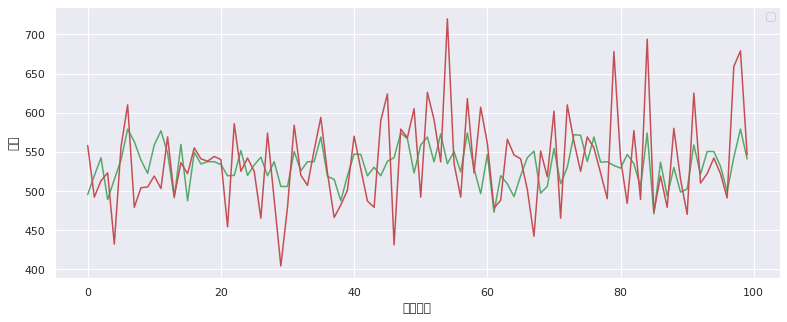

In [54]:
print('========================拟合线============================')
num = 100
plt.figure(figsize=(13,5))
plt.plot(range(num),pred_test[0:num], c='g',)  # 预测值
plt.plot(range(num),y_test[0:num], c='r',)  # 真实值

plt.xlabel('数据条数')
plt.ylabel('分数')
plt.legend()
plt.show()

### 分布比较

/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

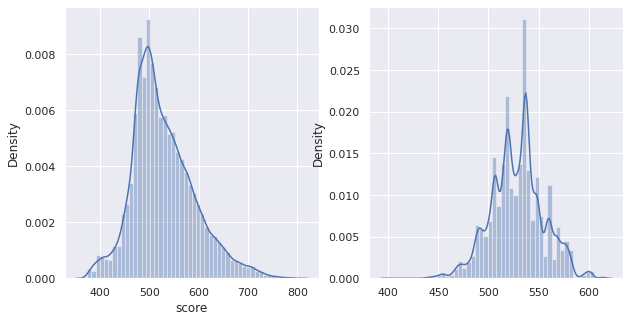

In [55]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))

sns.distplot(df['score'], ax=ax[0])  # 真实值
sns.distplot(xgb_reg_model.predict(df[['label_ids', 'game_ids']]), ax=ax[1])  # 预测值

### 随机验证
* 取df.head()的前N条记录，验证模型输出与实际值的偏差情况

In [56]:
df.head()

,image_id,image_name,label_ids,model_run_datetime,image_launch_time,game_ids,score
0,23237,SSR1399-横版（混剪）,511.852283,2020-12-18,2020-07-11,135.467769,478
1,23509,SSR1414-竖版（3D混剪）,530.618506,2020-12-18,2020-07-16,519.648437,571
2,23509,SSR1414-竖版（3D混剪）,530.618506,2020-12-18,2020-07-16,519.648437,500
3,23552,SSR1419-横版（3D混剪）,530.618506,2020-12-18,2020-07-14,482.070867,511
4,23846,SSR1484-横版（3D混剪）,530.618506,2020-12-18,2020-07-27,589.118843,540


In [57]:
for i in range(100):
    x = np.expand_dims(np.array([df.iloc[i]['label_ids'], df.iloc[i]['game_ids']]), axis=0)
    print("索引{}评分：预测值{:.2f}，真实值{}，偏差{}".format(i, xgb_reg_model.predict(x)[0], df.iloc[i]['score'], xgb_reg_model.predict(x) - df.iloc[i]['score']))

索引0评分：预测值466.31，真实值478，偏差[-11.691956]
索引1评分：预测值533.78，真实值571，偏差[-37.22339]
索引2评分：预测值533.78，真实值500，偏差[33.77661]
索引3评分：预测值525.89，真实值511，偏差[14.890564]
索引4评分：预测值525.46，真实值540，偏差[-14.539246]
索引5评分：预测值477.53，真实值458，偏差[19.530182]
索引6评分：预测值547.33，真实值640，偏差[-92.6687]
索引7评分：预测值562.21，真实值504，偏差[58.21466]
索引8评分：预测值559.76，真实值530，偏差[29.756165]
索引9评分：预测值559.76，真实值496，偏差[63.756165]
索引10评分：预测值494.62，真实值427，偏差[67.62024]
索引11评分：预测值494.62，真实值504，偏差[-9.379761]
索引12评分：预测值484.46，真实值471，偏差[13.455627]
索引13评分：预测值542.85，真实值634，偏差[-91.151794]
索引14评分：预测值542.85，真实值690，偏差[-147.1518]
索引15评分：预测值554.25，真实值584，偏差[-29.745728]
索引16评分：预测值515.47，真实值525，偏差[-9.534058]
索引17评分：预测值531.97，真实值554，偏差[-22.02533]
索引18评分：预测值514.27，真实值547，偏差[-32.732727]
索引19评分：预测值514.27，真实值496，偏差[18.267273]
索引20评分：预测值478.60，真实值394，偏差[84.60306]
索引21评分：预测值478.60，真实值551，偏差[-72.39694]
索引22评分：预测值537.00，真实值565，偏差[-27.999756]
索引23评分：预测值537.00，真实值532，偏差[5.000244]
索引24评分：预测值487.30，真实值431，偏差[56.299255]
索引25评分：预测值513.04，真实值497，偏差[16.036682]
索引26评分：预测值494.48，真实值54

### 模型保存

In [58]:
import joblib

In [59]:
# joblib.dump(xgb_reg_model, './aimodel/xgb_score.pt')

In [60]:
# df[['image_id', 'label_ids', 'game_ids', 'score']].iloc[:100]

In [61]:
# ============================================